# Spatio-temporal Anomaly Detection. 

Example with random graph and random signal.

Anomaly detection in the dynamics of web and social networks (2019). Volodymyr Miz, Benjamin Ricaud, Kirell Benzi, Pierre Vandergheynst

https://arxiv.org/abs/1901.09688

In this example, we use a random graph. The results largely depend on the structure of the graph. The results are much better when the structure of network makes sense. 

This is just a (very inefficient) demonstration for practitioners. If you need a scalable version and more efficient implementation, use the following code: https://github.com/epfl-lts2/sparkwiki/blob/master/src/main/scala/ch/epfl/lts2/wikipedia/PeakFinder.scala To run it, first, you need to deploy two databases with Wikipedia graph (Neo4J) and pagecounts time-series (Apache Cassandra). To do that, please follow the instructions from here: https://github.com/epfl-lts2/sparkwiki/tree/master/helpers

In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse import random
from scipy import stats
from matplotlib import pyplot as plt
import networkx as nx
import random

Plot formatting

In [2]:
# from pylab import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['xtick.labelsize'] = 70
# rcParams['ytick.labelsize'] = 70
# rcParams['font.size'] = 80

In [3]:
# plt.style.use('dark_background')

### 1. Generate synthetic time-series data

In [4]:
class CustomRandomState(np.random.RandomState):
    def randint(self, k):
        i = np.random.randint(k)
        return i - i % 2
np.random.seed(12345)
rs = CustomRandomState()
rvs = stats.poisson(25, loc=10).rvs

In [42]:
D = np.array(scipy.sparse.random(500, 5000, density=0.2, random_state=rs, data_rvs=rvs).todense())

Add anomalies

In [43]:
num_anomalous = 50
for i in random.sample(range(0, len(D)), num_anomalous):
    D[i][1000:1100] = np.random.uniform(low=200, high=300, size=(100,))

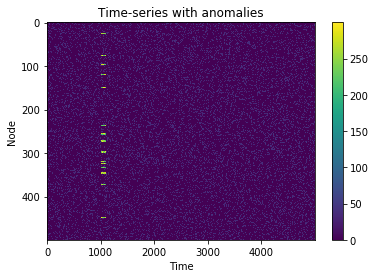

In [44]:
# plt.figure(figsize = (40,25))
plt.xlabel('Time')
plt.ylabel('Node')
plt.title('Time-series with anomalies')
plt.imshow(D, aspect='auto', )
plt.colorbar()

In [45]:
len(np.nonzero(D)[0])

504004

### 2. Generate random graph

Note, the initial random graph is very dense. The algorithm relies on the structure of the graph, therefore if you want to get better results, you need a graph that makes sense. For example, a social or hyperlinks network. Unless you have this kind of structure behind your data, I recommend constructing a nearest neighbors graph.

In [46]:
W = np.array(scipy.sparse.random(500, 500, density=0.05, random_state=rs, data_rvs=rvs).todense())

In [47]:
W = np.where(W > 0, 1, W)

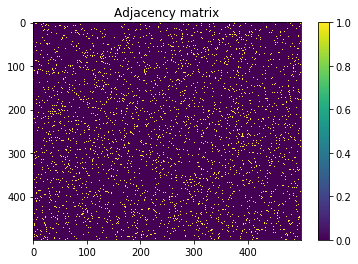

In [48]:
plt.imshow(W, aspect='auto')
plt.title('Adjacency matrix')
plt.colorbar()

In [49]:
G = nx.from_numpy_matrix(W)

In [50]:
nx.write_gexf(G, 'graph.gexf')

### 3. Find peaks

In [51]:
# Very simple peak detection function based on standard deviation
# This function can be replaced. Tweak it according to your data domain. 
# For example, if you work with finantial time-series, you might want to remove daily/monthly fluctuations and use z-score do tetect peaks.
def std_peaks(signal, threshold):
    std = np.std(signal)
    filtered = [v if v > threshold * std else 0 for v in signal]
    return filtered

In [52]:
threshold = 3 # we discard all values that are lower than threshold * std. Play with this paramenter to keep/remove more time-stamps.

In [53]:
D_peaks = np.apply_along_axis(std_peaks, 0, D, threshold)

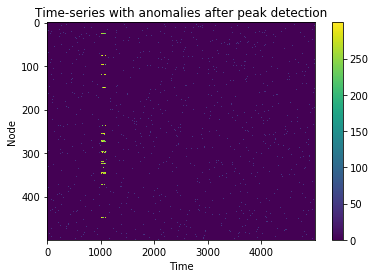

In [54]:
plt.xlabel('Time')
plt.ylabel('Node')
plt.title('Time-series with anomalies after peak detection')
plt.imshow(D_peaks, aspect='auto')
plt.colorbar()

In [55]:
len(np.nonzero(D_peaks)[0])

40829

### 4. Learning

In [56]:
"""

Hebbian learning.

Go through all neurons in the reservoir and apply 
Hebbian learning rule (Wiki-like weight update).

@NOTE: Very inefficient but intuitive and neat implementation.
@TODO: implement in a parallel fashion.

"""
min_weight = 1.0 # weight threshold applied after learning. Edges with weight below min_weight are removed
edge_weights = {}
for edge in G.edges:
    w = 0
    # NOTE: the logic below is very simplified and can be replaced with any other similarity function. Tweak this according to yor data domain.
    for tpl in zip(D_peaks[edge[0]], D_peaks[edge[1]]):
        sim = min(tpl[0], tpl[1])/max(tpl[0], tpl[1])
        if sim > 0.5: #both activations positive
            w += sim
        else:
            w += 0.0
    # remove low-weight edges
    if w > min_weight:
        edge_weights[edge] = w
    else:
        edge_weights[edge] = 0.0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [57]:
G_learned = G

In [58]:
# save graph with anomalous cluster
nx.set_edge_attributes(G_learned, name = 'weight', values = edge_weights)
nx.write_gexf(G_learned, 'graph_learned.gexf')